# How to do advanced model manipulation and fitting in Python?

In this tutorial you will learn to perform some more advanced model manipulation and fitting from Python. You can use these methods in an interactive Python session to explore your dataset and improve the known model of the sky. You can also use them in a Python pipeline to test multiple model hypotheses and select the one that is most appropriate.

As usual start by importing the gammalib, ctools, and cscripts Python modules.

In [1]:
import gammalib
import ctools
import cscripts

Now import the matplotlib package for plotting.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

## Simulated dataset

For the tutorial you will simulate a small dataset. Start by defining the Instrument Response Function and energy range that will be used all along.

In [3]:
caldb = 'prod2'
irf   = 'South_0.5h'
emin  = 0.1   # TeV
emax  = 160.0 # TeV

Now proceed to simulate the dataset. It consists of an hour of observations of the Crab nebula region, as usual pointed at a slightly offset position from the target. The input model is different from the one you have been using so far and contains some surprises. Don't look at it until you have completed the exercises at the end of the tutorial.

In [4]:
evfile = 'events.fits'
obssim = ctools.ctobssim()
obssim['ra']        = 83.63
obssim['dec']       = 22.51
obssim['rad']       = 5.0
obssim['tmin']      = 0
obssim['tmax']      = 3600
obssim['emin']      = emin
obssim['emax']      = emax
obssim['caldb']     = caldb
obssim['irf']       = irf
obssim['inmodel']   = '$CTOOLS/share/models/crab_beyond.xml'
obssim['outevents'] = evfile
obssim.execute()

You have saved the events on disk in the file `events.fits`. In this way you can easily re-use the code below by substituting `events.fits` with your own event list or observation definition XML file.

Let's first peek at the simulated dataset by displaying a skymap.

In [5]:
skymap = ctools.ctskymap()
skymap['inobs']       = evfile
skymap['emin']        = emin
skymap['emax']        = emax
skymap['nxpix']       = 40
skymap['nypix']       = 40
skymap['binsz']       = 0.02
skymap['proj']        = 'TAN'
skymap['coordsys']    = 'CEL'
skymap['xref']        = 83.63
skymap['yref']        = 22.01
skymap['bkgsubtract'] = 'IRF'
skymap['caldb']       = caldb
skymap['irf']         = irf
skymap.run()

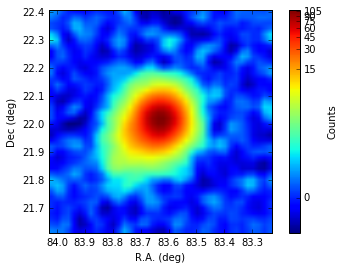

In [6]:
# Slightly smooth the map for display to suppress statistical fluctuations
skymap.skymap().smooth('GAUSSIAN',0.02)

from matplotlib.colors import SymLogNorm
# The SymLogNorm scale is a Log scale for both positive and negative values
# and is linear within a certain range around 0

ax = plt.subplot()
plt.imshow(skymap.skymap().array(),origin='lower',
           extent=[83.63+0.02*20,83.63-0.02*20,22.01-0.02*20,22.01+0.02*20],
           # boundaries of the coord grid
           norm=SymLogNorm(1)) # the scale will be linear within +-1 count 
ax.set_xlabel('R.A. (deg)')
ax.set_ylabel('Dec (deg)')
cbar = plt.colorbar()
cbar.set_label('Counts')

## Model fitting and residual inspection

First, fit the usual Crab model to the data using a 3D unbinned analysis.

In [7]:
like = ctools.ctlike()
like['inobs']   = evfile
like['caldb']   = caldb
like['irf']     = irf
like['inmodel'] = '$CTOOLS/share/models/crab.xml'
like.run()

As usual it is wise to look at the output from the optimizer. Store the best-fit minus log-likelihood value for later usage.

In [8]:
print(like.opt())
like1 = like.opt().value()

=== GOptimizerLM ===
 Optimized function value ..: 314283.848
 Absolute precision ........: 0.005
 Acceptable value decrease .: 2
 Optimization status .......: converged
 Number of parameters ......: 10
 Number of free parameters .: 4
 Number of iterations ......: 10
 Lambda ....................: 1e-09


The fit has properly converged after 10 iterations. Let's take a look at the best-fit model.

In [9]:
print(like.obs().models())

=== GModels ===
 Number of models ..........: 2
 Number of parameters ......: 10
=== GModelSky ===
 Name ......................: Crab
 Instruments ...............: all
 Observation identifiers ...: all
 Model type ................: PointSource
 Model components ..........: "PointSource" * "PowerLaw" * "Constant"
 Number of parameters ......: 6
 Number of spatial par's ...: 2
  RA .......................: 83.6331 [-360,360] deg (fixed,scale=1)
  DEC ......................: 22.0145 [-90,90] deg (fixed,scale=1)
 Number of spectral par's ..: 3
  Prefactor ................: 3.53420599763427e-16 +/- 6.13986831272974e-18 [1e-23,1e-13] ph/cm2/s/MeV (free,scale=1e-16,gradient)
  Index ....................: -2.27926376645739 +/- 0.0145867158537894 [-0,-5]  (free,scale=-1,gradient)
  PivotEnergy ..............: 300000 [10000,1000000000] MeV (fixed,scale=1000000,gradient)
 Number of temporal par's ..: 1
  Normalization ............: 1 (relative value) (fixed,scale=1,gradient)
 Number of scale par'

The background model reproduces well the data, since its best-fit normalization is 1 and the index/tilt is 0. The Crab nebula has a best-fit spectral index of 2.28.

To assess whether the model reproduces well the data spatially generate a residual map.

In [10]:
resmap = cscripts.csresmap(like.obs())
resmap['algorithm'] = 'SIGNIFICANCE'
resmap['emin']      = emin
resmap['emax']      = emax
resmap['nxpix']     = 40
resmap['nypix']     = 40
resmap['binsz']     = 0.02
resmap['proj']      = 'TAN'
resmap['coordsys']  = 'CEL'
resmap['xref']      = 83.63
resmap['yref']      = 22.01
resmap.run()

To easily inspecting the residual maps along the tutorial, define a function to plot them, and apply it to the latest run.

In [11]:
def plot_residuals(resid):
    # Slightly smooth the map for display to suppress statistical fluctuations
    resid.smooth('GAUSSIAN',0.04)
    # Plotting
    fig = plt.figure()
    ax  = plt.subplot()
    plt.imshow(resid.array(),origin='lower',
               cmap='bwr',vmin=-3,vmax=3,
               extent=[83.63+0.02*20,83.63-0.02*20,22.01-0.02*20,22.01+0.02*20])
               # Boundaries of the coord grid
    ax.set_xlabel('R.A. (deg)')
    ax.set_ylabel('Dec (deg)')
    cbar = plt.colorbar()
    cbar.set_label('Significance ($\sigma$)')

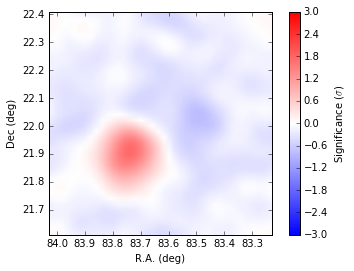

In [12]:
plot_residuals(resmap._resmap)

## Adding model components

The residual map shows a cluster of positive residuals on the South-West of the Crab nebula. Is this another source? To test this hypothesis add a point source at the position that you can guess from the residual map.

In [13]:
newpntsrc = gammalib.GModelSky(gammalib.GModelSpatialPointSource(83.7,21.9),
                               gammalib.GModelSpectralPlaw(1.e-17,-2.,gammalib.GEnergy(3.e5,'MeV')),
                               gammalib.GModelTemporalConst(1))

You have defined a sky model object that has three components:

- a spatial model, which is a point source at the position guessed from the residual map;
- a spectral model which is a power law with spectral index 2, and a flux which approximately 1/10 of the Crab nebula;
- a temporal model which is a constant.

Name this source `Src1`, and free its position (fixed by default when a new source is created), so that you can fit it to the data:

In [14]:
newpntsrc.name('Src1')
newpntsrc['RA'].free()
newpntsrc['DEC'].free()

Finally append the new source to the model container

In [15]:
like.obs().models().append(newpntsrc)

<gammalib.model.GModelSky; proxy of <Swig Object of type 'GModelSky *' at 0x10e32d120> >

and fit the model including the new source to the data.

In [16]:
like.run()

Does the addition of the new source provide a better fit to the data? You can quantify this using the test statistic (TS) given by twice the log-likelihood difference.

In [17]:
like2 = like.opt().value()
ts    = -2.0 * (like2 - like1)
print(ts)

189.902171128


TS is expected to be distributed as a $\chi^2_n$ with n degrees of freedom, where n is the additional number of degrees of freedom in the model including the new source, in our case 4 (RA, Dec, Prefactor, and Index). The integral of the $\chi^2_n$ from TS to $\infty$ is the chance probability that the likelihood improved by that much due to statistical fluctuations. A large value, like the one we got, means that the chance probability is very low, thus we are likely to have found a new source.

To make sure the new source improves the data/model agreement look again at the residual map.

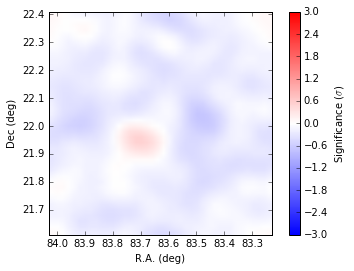

In [18]:
resmap.models(like.obs().models())
resmap.run()
plot_residuals(resmap._resmap)

The addition of the new point source has flattened the spatial residuals, even though the fit is obviously not perfect yet. From now on fix the position of `Src1`.

In [19]:
like.obs().models()['Src1']['RA'].fix()
like.obs().models()['Src1']['DEC'].fix()

## Modifying the spectral models

Next check if the model agrees well with the data at all energies. Start by defining a function to make and plot residual maps in separate energy ranges.

In [20]:
def resmap_erange(ebounds):
    for elow, eup in ebounds:
        resmap['emin'] = elow
        resmap['emax'] = eup
        resmap.models(like.obs().models()) # we make sure we are using the latest best-fit model
        resmap.run()
        plot_residuals(resmap._resmap)

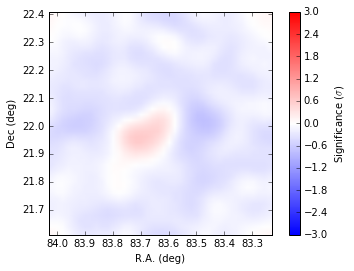

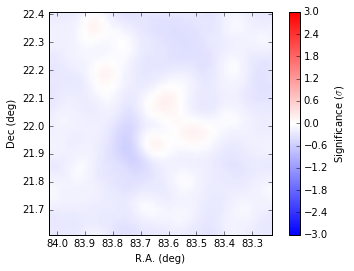

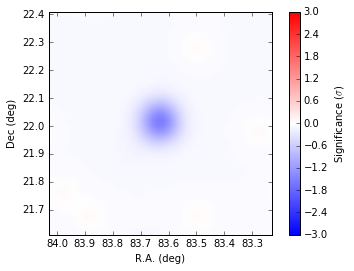

In [21]:
resmap_erange([[emin,1.],
               [1.,10.],
               [10.,emax]])

The most obvious problem is a negative residual cluster at the position of the Crab nebula at the highest energies. Change the spectral model of the Crab nebula and test if this improves the fit. Try for example an exponentially cutoff power-law rather than a simple power law. Let's use as starting values for the Prefactor and Index the current best-fit values and tentatively set the cutoff energy at 1 TeV.

In [22]:
crab    = like.obs().models()['Crab']
expplaw = gammalib.GModelSpectralExpPlaw()
expplaw['Prefactor'].value(crab['Prefactor'].value())
expplaw['Index'].value(crab['Index'].value())
expplaw['PivotEnergy'].value(crab['PivotEnergy'].value())
expplaw['CutoffEnergy'].value(1.e6)
crab.spectral(expplaw)

Now fit the modified model to the data

In [23]:
like.run()

and use TS to quantify the model improvement (in this case there is only one additional degree of freedom, the ctuoff energy).

In [24]:
like3 = like.opt().value()
ts    = -2.0 * (like3 - like2)
print(ts)

319.823191288


The model improvement was again significant. Let's look at the fit results for the Crab nebula.

In [25]:
print(crab)

=== GModelSky ===
 Name ......................: Crab
 Instruments ...............: all
 Observation identifiers ...: all
 Model type ................: PointSource
 Model components ..........: "PointSource" * "ExponentialCutoffPowerLaw" * "Constant"
 Number of parameters ......: 7
 Number of spatial par's ...: 2
  RA .......................: 83.6331 [-360,360] deg (fixed,scale=1)
  DEC ......................: 22.0145 [-90,90] deg (fixed,scale=1)
 Number of spectral par's ..: 4
  Prefactor ................: 3.59476304274447e-16 +/- 7.19602145430449e-18 [0,infty[ ph/cm2/s/MeV (free,scale=1,gradient)
  Index ....................: -1.82160618592727 +/- 0.0226092702974795 [-10,10]  (free,scale=1,gradient)
  CutoffEnergy .............: 3206993.95272881 +/- 117129.972166476 [0.1,infty[ MeV (free,scale=1,gradient)
  PivotEnergy ..............: 300000 MeV (fixed,scale=1,gradient)
 Number of temporal par's ..: 1
  Normalization ............: 1 (relative value) (fixed,scale=1,gradient)
 Number of

The best-fit cutoff energy is 3.2 TeV, which seems consistent with the behavior in the energy-bands residual maps above. Note that this has changed significantly the Index value, that now is 1.82. Check the residual maps again to make sure that the residuals are reduced.

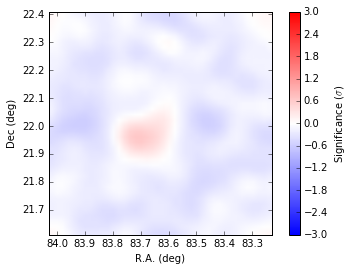

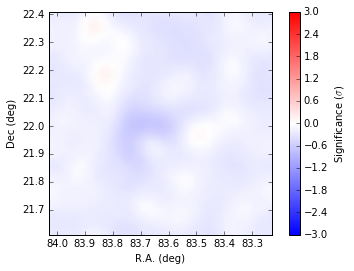

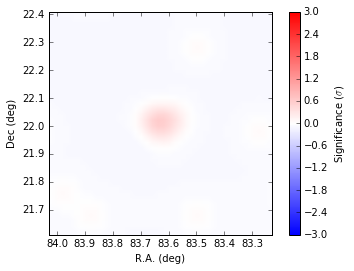

In [26]:
resmap_erange([[emin,1.],
               [1.,10.],
               [10.,emax]])

Now you actually have an excess at the highest energies. In spite of the significant likelihood improvement the model is not quite perfect yet. Is there perhaps a new spectral component appearing at high energies? Test if the addition of a power-law spectral component with a hard index (2) improves things. To do this, add the hard spectral component to the exponentially-cutoff power law using a composite spectral model.

In [27]:
expplaw2  = like.obs().models()['Crab'].spectral().clone() 
newcomp   = gammalib.GModelSpectralPlaw(1.e-18,-2.,gammalib.GEnergy(1,'TeV'))
comp_spec = gammalib.GModelSpectralComposite()
comp_spec.append(expplaw2)
comp_spec.append(newcomp)
like.obs().models()['Crab'].spectral(comp_spec)

Let's fit this new model to the data and check the likelihood improvement.

In [28]:
like.run()
like4 = like.opt().value()
ts    = -2.0 * (like4 - like3)
print(ts)

311.120290752


The likelihood improvement is again significant, but is this the best possible model of the sky?

## Exercises 

- Test other spectral models for the Crab nebula, such as log-parabola and broken power law. Can you say what the best spectral model is?
- What can you say from the residual maps about the spectrum of `Src1`? Try looking at the residuals below and above 300 GeV.
- Replace the 2 sources with a single extended source (disk). Can you say which of the two hypotheses is describing the data better?